In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [5]:
import sys
sys.path.append("../")

In [6]:

from dataclasses import replace
from pathlib import Path
import pickle

import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, cdist
import seaborn as sns
from sklearn.decomposition import PCA
from tqdm.auto import tqdm

from src.analysis import coherence
from src.analysis.state_space import prepare_state_trajectory, StateSpaceAnalysisSpec
from src.datasets.speech_equivalence import SpeechEquivalenceDataset
from src.models import get_best_checkpoint
from src.models.integrator import ContrastiveEmbeddingModel, compute_embeddings, load_or_compute_embeddings

In [31]:
model_dir = "outputs/models/w2v2_6_8/phoneme_within_word_suffix"
# equiv_dataset_path = "../data/timit_equiv_phoneme_within_word_prefix_1.pkl"
# model_checkpoint = "../out/ce_model_phoneme_6_32/checkpoint-800/"
equiv_dataset_path = "data/timit_equivalence_facebook-wav2vec2-base_6-phoneme-1.pkl"

state_space_spec_path = "out/state_space_specs/all_words.pkl"
output_dir = "."

metric = "cosine"

In [32]:
model = ContrastiveEmbeddingModel.from_pretrained(get_best_checkpoint(model_dir))
model.eval()

ContrastiveEmbeddingModel(
  (rnn): RNNModel(
    (rnn): LSTM(768, 32, batch_first=True)
    (fc): Linear(in_features=32, out_features=8, bias=True)
  )
)

In [33]:
with open(equiv_dataset_path, "rb") as f:
    equiv_dataset: SpeechEquivalenceDataset = pickle.load(f)

In [34]:
with open(state_space_spec_path, "rb") as f:
    state_space_spec: StateSpaceAnalysisSpec = pickle.load(f)
assert state_space_spec.is_compatible_with(equiv_dataset)

In [35]:
model_representations = load_or_compute_embeddings(model, equiv_dataset, model_dir, equiv_dataset_path)

In [36]:
# Retain only words with N or more instances
retain_n = 10
drop_idxs = [idx for idx, target_frames in enumerate(state_space_spec.target_frame_spans)
               if len(target_frames) < retain_n]
state_space_spec = state_space_spec.drop_labels(drop_idxs)

In [37]:
trajectory = prepare_state_trajectory(model_representations, state_space_spec, pad=np.nan)

In [38]:
lengths = [np.isnan(traj_i[:, :, 0]).argmax(axis=1) for traj_i in trajectory]

In [39]:
len(trajectory)

439

## Estimate within-word distance

In [40]:
within_distance, within_distance_offset = \
    coherence.estimate_within_distance(trajectory, lengths, state_space_spec, metric=metric)

  0%|          | 0/439 [00:00<?, ?it/s]

<Axes: >

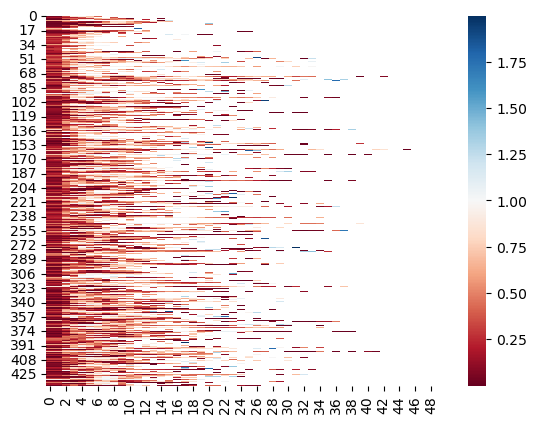

In [41]:
sns.heatmap(within_distance, center=1, cmap="RdBu")

In [42]:
within_distance_df = pd.DataFrame(within_distance, index=pd.Index(state_space_spec.labels, name="word")) \
    .reset_index() \
    .melt(id_vars=["word"], var_name="frame", value_name="distance")

In [43]:
within_distance_offset_df = pd.DataFrame(within_distance_offset, index=pd.Index(state_space_spec.labels, name="word")) \
    .reset_index() \
    .melt(id_vars=["word"], var_name="frame", value_name="distance")

## Estimate between-word distance

In [44]:
between_distance, between_distance_offset = \
    coherence.estimate_between_distance(trajectory, lengths, state_space_spec,
                                        metric=metric)

  0%|          | 0/439 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/analysis/coherence.py:14: RuntimeWarning: Mean of empty slice.
  return distances[distances != 0].mean()
/home/jgauthier/u/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [45]:
between_distances_df = pd.DataFrame(np.nanmean(between_distance, axis=-1),
                                    index=pd.Index(state_space_spec.labels, name="word")) \
    .reset_index() \
    .melt(id_vars=["word"], var_name="frame", value_name="distance")

/tmp/ipykernel_1562882/1636428382.py:1: RuntimeWarning: Mean of empty slice
  between_distances_df = pd.DataFrame(np.nanmean(between_distance, axis=-1),


In [46]:
between_distances_offset_df = pd.DataFrame(np.nanmean(between_distance_offset, axis=-1),
                                    index=pd.Index(state_space_spec.labels, name="word")) \
    .reset_index() \
    .melt(id_vars=["word"], var_name="frame", value_name="distance")

/tmp/ipykernel_1562882/3903637063.py:1: RuntimeWarning: Mean of empty slice
  between_distances_offset_df = pd.DataFrame(np.nanmean(between_distance_offset, axis=-1),


## Together

In [47]:
merged_df = pd.concat([within_distance_df.assign(type="within"), between_distances_df.assign(type="between")])
merged_df.to_csv(Path(output_dir) / "distances.csv", index=False)
merged_df

,word,frame,distance,type
0,she,0,0.052702,within
1,had,0,0.166061,within
2,your,0,0.208603,within
3,dark,0,0.031571,within
4,suit,0,0.013372,within
...,...,...,...,...
21945,hallway,49,NaN,between
21946,gift,49,NaN,between
21947,run,49,NaN,between
21948,hung,49,NaN,between


Text(0, 0.5, 'Cosine distance')

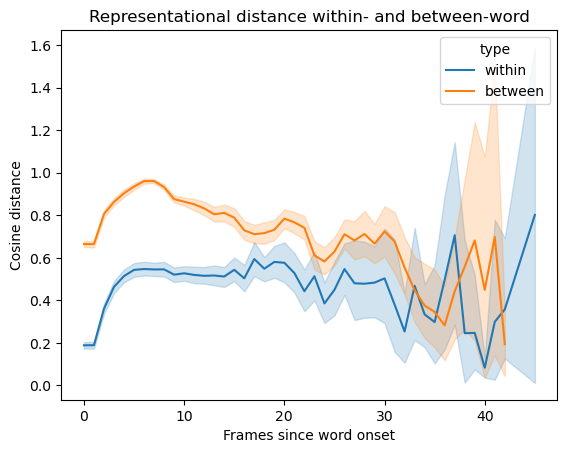

In [48]:
ax = sns.lineplot(data=merged_df.dropna(), x="frame", y="distance", hue="type")
ax.set_title("Representational distance within- and between-word")
ax.set_xlabel("Frames since word onset")
ax.set_ylabel(f"{metric.capitalize()} distance")

In [49]:
merged_offset_df = pd.concat([within_distance_offset_df.assign(type="within"),
                              between_distances_offset_df.assign(type="between")])
merged_offset_df.to_csv(Path(output_dir) / "distances_aligned_offset.csv", index=False)
merged_offset_df

,word,frame,distance,type
0,she,0,NaN,within
1,had,0,NaN,within
2,your,0,NaN,within
3,dark,0,NaN,within
4,suit,0,NaN,within
...,...,...,...,...
21945,hallway,49,NaN,between
21946,gift,49,NaN,between
21947,run,49,NaN,between
21948,hung,49,NaN,between


(0.0, 24.0)

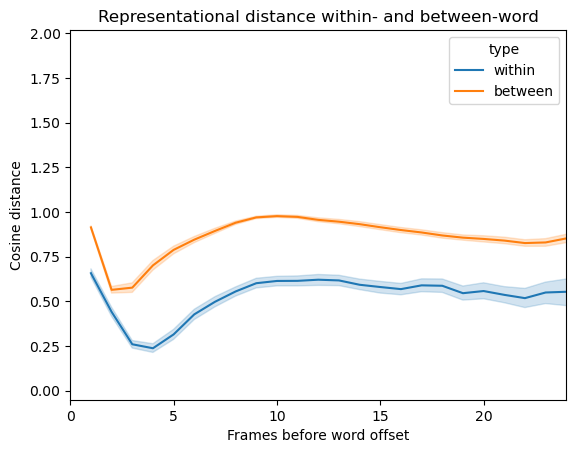

In [50]:
ax = sns.lineplot(data=merged_offset_df.dropna(),
                  x="frame", y="distance", hue="type")
ax.set_title("Representational distance within- and between-word")
ax.set_xlabel("Frames before word offset")
ax.set_ylabel(f"{metric.capitalize()} distance")
ax.set_xlim((0, np.percentile(np.concatenate(lengths), 95)))

## Estimate distance by grouping features

### Onset

In [51]:
onsets = [word[0] for word in state_space_spec.labels]

onset_distance_df, onset_distance_offset_df = coherence.estimate_category_within_between_distance(
    trajectory, lengths, onsets, metric=metric, labels=state_space_spec.labels
)

  0%|          | 0/439 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/analysis/coherence.py:14: RuntimeWarning: Mean of empty slice.
  return distances[distances != 0].mean()
/home/jgauthier/u/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


  0%|          | 0/439 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/analysis/coherence.py:143: RuntimeWarning: Mean of empty slice
  merged_df = pd.concat([matched_df.assign(type="matched"), mismatched_df.assign(type="mismatched")])
/userdata/jgauthier/projects/ideal-word-representations/src/analysis/coherence.py:145: RuntimeWarning: Mean of empty slice
  matched_offset_df = pd.DataFrame(np.nanmean(matched_distances_offset, axis=-1), index=pd.Index(labels, name="label"))
/userdata/jgauthier/projects/ideal-word-representations/src/analysis/coherence.py:149: RuntimeWarning: Mean of empty slice
  return merged_df, merged_offset_df
/userdata/jgauthier/projects/ideal-word-representations/src/analysis/coherence.py:151: RuntimeWarning: Mean of empty slice


In [55]:
onset_distance_df.to_csv(Path(output_dir) / "distances-grouped_onset.csv", index=False)

Text(0, 0.5, 'Cosine distance')

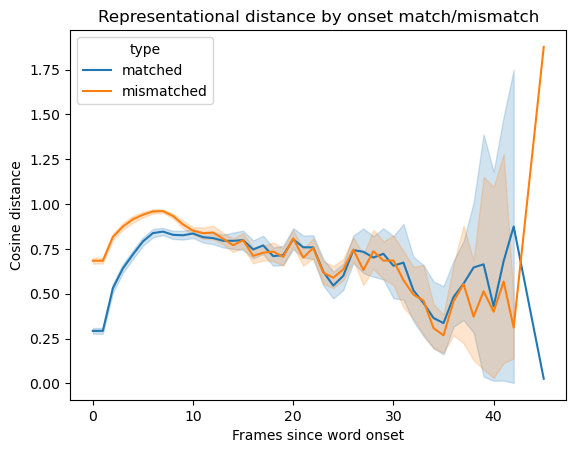

In [52]:
ax = sns.lineplot(data=onset_distance_df.dropna(), x="frame", y="distance", hue="type")
ax.set_title("Representational distance by onset match/mismatch")
ax.set_xlabel("Frames since word onset")
ax.set_ylabel(f"{metric.capitalize()} distance")

### Offset

In [53]:
offsets = [word[-1] for word in state_space_spec.labels]

offset_distance_df, offset_distance_offset_df = coherence.estimate_category_within_between_distance(
    trajectory, lengths, offsets, metric=metric, labels=state_space_spec.labels
)

  0%|          | 0/439 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/analysis/coherence.py:14: RuntimeWarning: Mean of empty slice.
  return distances[distances != 0].mean()
/home/jgauthier/u/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


  0%|          | 0/439 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/analysis/coherence.py:143: RuntimeWarning: Mean of empty slice
  merged_df = pd.concat([matched_df.assign(type="matched"), mismatched_df.assign(type="mismatched")])
/userdata/jgauthier/projects/ideal-word-representations/src/analysis/coherence.py:145: RuntimeWarning: Mean of empty slice
  matched_offset_df = pd.DataFrame(np.nanmean(matched_distances_offset, axis=-1), index=pd.Index(labels, name="label"))
/userdata/jgauthier/projects/ideal-word-representations/src/analysis/coherence.py:149: RuntimeWarning: Mean of empty slice
  return merged_df, merged_offset_df
/userdata/jgauthier/projects/ideal-word-representations/src/analysis/coherence.py:151: RuntimeWarning: Mean of empty slice


In [56]:
offset_distance_offset_df.to_csv(Path(output_dir) / "distances-grouped_offset-relative_to_offset.csv", index=False)

Text(0, 0.5, 'Cosine distance')

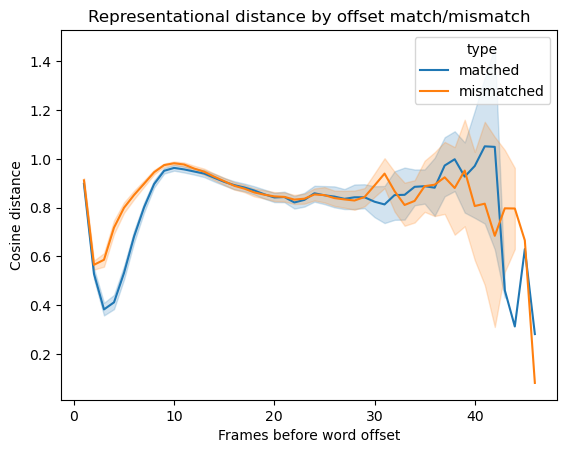

In [57]:
ax = sns.lineplot(data=offset_distance_offset_df.dropna(), x="frame", y="distance", hue="type")
ax.set_title("Representational distance by offset match/mismatch")
ax.set_xlabel("Frames before word offset")
ax.set_ylabel(f"{metric.capitalize()} distance")